# Fairness in complex network analysis

(FT) Some concepts I see from the references:

* robustness (discussed in our Chapter 10)
* accuracy (discussed in many places in our book)
* explainability
* fairness&equity
* sensitivity&stability (example in chapter 5 of our book, for clustering)
* reliability
* privacy preserving

Not sure about simple experiments for explainability, fairness&equity, reliability and privacy preserving, but we can at least explain those concepts.
The example in Tina’s talk relates to sensitivity&stability. Some possible simple experiment:

* pick a ‘good’ embedding algorithm and apply to some ABCD graph as is, and then with some increasing proportion of edges removed (say 5%, 10%, 15% … we need to try); compare the embeddings with:
 * change in kNN for each node
 * some follow-up task like k-means clustering
* re-do the above for a ‘less good’ algorithm ; less stable?

Fairness experiments ideas:
* group fairness: discrimination, minority/majority (race, gender) ; surrogate could be clusters
* individual fairness: for example, compare node’s output with its kNNs in a classification task
* degree-based fairness: high/low degree nodes may be treated differently in some algorithms

---

(BK) If I understand correctly the sub-chapter should be:
1. definition of fairness measures
2. discussion that we cannot ensure all fairness measures at the same time (and that one has to decide what kind of fairness one wants)
3. discussion of "protected features" (like: sex, race)
4. Maybe discussion if "degree" (or other graph features) should be considered as a "protected feature"
5. discussion of node classification/regression and edge prediction/classification/regression context
6. some examples (like what Francois did - where fairness is defined as equality of prediction quality vs. a protected feature)

The question is if it is not too much (alternatively we could concentrate on an example on a single fairness measure vs a single protected feature as an example and in the conclusion add references that there are other options).

---

Add node features, predict feature (eg. credit score) ; bias w.r.t. community size w.r.t. quality of prediction?
Add other features such as degree, etc.

PP: use ABCD-oo cookie model as features to be predicted ;



In [1]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from collections import Counter
import os
import umap
import pickle
import partition_igraph
import subprocess
from sklearn.metrics import adjusted_mutual_info_score as AMI
import random 
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
from abcd_graph import ABCDGraph, ABCDParams
import sknetwork as skn
from sknetwork.classification import get_accuracy_score


## we use those for the book, but you can change to other colors
cls_edges = 'gainsboro'
cls = ['white','gray','dimgray','black']


In [2]:
def build_ABCD(n=10000, gamma=2.5, delta=5, Delta=50, beta=1.5, s=100, S=8000, xi=0.65, seed=321):
    zeta = np.log(Delta) / np.log(n)
    tau = np.log(S) / np.log(n)
    np.random.seed(seed)
    random.seed(seed)
    params = ABCDParams(vcount=n, gamma=gamma, min_degree=delta, max_degree=Delta, beta=beta, min_community_size=s, max_community_size=S, xi=xi)
    g = ABCDGraph(params).build()
    G = g.exporter.to_igraph()
    return G


In [3]:
def apply_GNN(G, test_prop = 0.5, seed=12, verbose=True):
    labels = np.array(G.vs['ground_truth_community'], dtype='int')
    G_A = G.get_adjacency_sparse()
    nc = np.max(G.vs['ground_truth_community'])+1    
    np.random.seed(seed)
    train_mask = np.random.random(size=len(labels)) < 0.5 ## mask nodes for training
    labels[train_mask] = -1 ## the negative labels are ignored in the training
    
    # GNN classifier with a single hidden layer
    hidden_dim = 2*nc
    n_labels = nc ## ground-truth communities 
    gnn = skn.gnn.GNNClassifier(dims=[hidden_dim, n_labels],
                        layer_types='Conv',
                        activations='ReLu',
                        verbose=False)
    
    ## for features, we simply use the adjacency matrix
    features = G_A
    
    ## fit the GCN
    Pred = gnn.fit_predict(G_A, features, labels=labels, n_epochs=50, random_state=42)
    
    if verbose:
        ## apply to test set and compute accuracy
        acc = get_accuracy_score(np.array(G.vs['ground_truth_community'])[train_mask], Pred[train_mask])
        print('accuracy on the test set:', acc)

    return Pred, train_mask


## Degree fairness

From the survey, there is a description of group fairness (gender, race ...), individual fairness and interestingly, degree fairness.

A very simple experiment we could show is to classify ABCD nodes with a GNN, and look at the degree of misclassified nodes
in the test set vs the other nodes. 

One expects more misclassified low degree nodes.


In [4]:
G = build_ABCD(n=10000, gamma=2.5, delta=5, Delta=100, beta=1.5, s=100, S=1000, xi=0.65, seed=321)
comms = G.vs['ground_truth_community'] 
print(AMI(G.community_ecg(ens_size=16, final='leiden').membership, G.vs['ground_truth_community']))


0.320020277481615


In [5]:
## classification
Pred, train_mask = apply_GNN(G)


accuracy on the test set: 0.7313935075217736


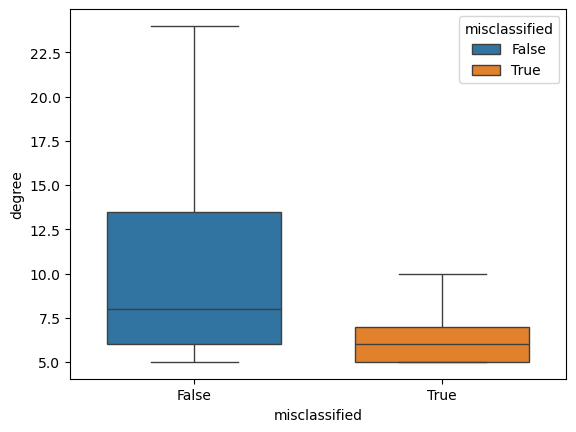

In [6]:
## misclassified vs degree and cluster size
misclass = [i for i in np.where(train_mask)[0] if (Pred[i] != G.vs['ground_truth_community'][i]) ]
correct = [i for i in np.where(train_mask)[0] if (Pred[i] == G.vs['ground_truth_community'][i]) ]

## plot
df = pd.DataFrame()
df['misclassified'] = [Pred[i] != G.vs['ground_truth_community'][i] for i in np.where(train_mask)[0]]
df['degree'] = G.degree(np.where(train_mask)[0])
sns.boxplot(df, x='misclassified', y='degree', showfliers=False, hue='misclassified', width=.7)
plt.show()


## Community size fairness

A similar experiment as I shared last month (degree bias) is to consider community sizes, where small communities can be seen as surrogate for "minority groups".

I generated another ABCD graph with highly variable community sizes (smallest = 103, largest = 3772).

Again I run a GNN classifier. There is a clear bias toward smaller community sizes for misclassified nodes.
If we look at the misclassified nodes in the smallest community, most are assigned to the two largest communities:
Counter({3772: 17, 1493: 5, 487: 3, 119: 2, 580: 1, 303: 1, 446: 1})




In [7]:
G = build_ABCD(n=10000, gamma=2.5, delta=5, Delta=50, beta=1.5, s=100, S=8000, xi=0.65, seed=321)
comm_sizes = Counter(G.vs['ground_truth_community'])
G.vs['comm_size'] = [comm_sizes[i] for i in G.vs['ground_truth_community']]

## classification
Pred, train_mask = apply_GNN(G)


accuracy on the test set: 0.7001187648456056


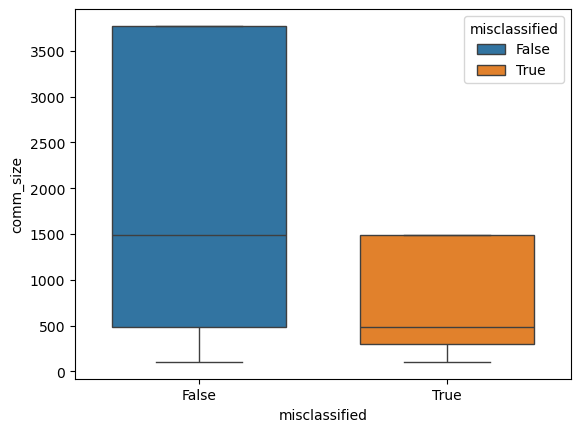

In [8]:
## misclassified vs degree and cluster size
misclass = [i for i in np.where(train_mask)[0] if (Pred[i] != G.vs['ground_truth_community'][i]) ]
correct = [i for i in np.where(train_mask)[0] if (Pred[i] == G.vs['ground_truth_community'][i]) ]

## plot
df = pd.DataFrame()
df['misclassified'] = [Pred[i] != G.vs['ground_truth_community'][i] for i in np.where(train_mask)[0]]
df['comm_size'] = [G.vs['comm_size'][i] for i in np.where(train_mask)[0]]
sns.boxplot(df, x='misclassified', y='comm_size', showfliers=False, hue='misclassified', width=.7)
plt.show()


In [9]:
## community sizes vs predicted community sizes 
df['pred_comm_size'] = [comm_sizes[Pred[i]] for i in np.where(train_mask)[0]]
df.groupby(by='misclassified').mean()

,comm_size,pred_comm_size
misclassified,,
False,2121.243992,2121.243992
True,1143.032343,2252.792739


In [10]:
## true community size smaller than predicted community size?
Counter(df[df.misclassified==True]['comm_size'] < df[df.misclassified==True]['pred_comm_size'])


Counter({True: 1058, False: 457})

In [11]:
## predicted community sizes - smallest community misclassified points
smallest = min(df.comm_size)
Counter(df[ (df.comm_size==smallest) & (df.misclassified==True) ]['pred_comm_size'])


Counter({3772: 14, 1493: 3, 487: 1, 303: 1, 151: 1})